# PPO 
### Author: Gerti Tuzi

###### Network:
 - Shared latent features body
 - Action head (mean): used in Normal(mu, sig)
 - Value head: estimates the return
 
##### Highlights:
 - CRITICAL: Std. deviation parameter of the policy is NOT learned. 
    Rather it is used as an exploratory parameter (stochastic policy, remember ?).
    Similar to eps in greedy-eps (i.e. linearly annealed).
 - No gradients are computed starting from std. deviation which we're modifying. 
    This is not too clear from paper.
 - Std. dev parametrized as log(std.dev)
 - Used disounted future returns as V_target (needed in value loss, VF, computation).
 - Mean normalized advantages
 - Using GAE, generalized advantage estimation (?) form, just like in paper.
 - Log std.dev is annealed linearly 
 - Large batch size for multiple-agents
 - Number of training epochs (after each episode) is large (~10 to ~20)
 - Important: buffer must be large enough for all agents over each rollout.
 - LR and eps-clip are annealed linearly using multipicative alpha (1 --> 0)
 - Value loss (VF) coefficient 10 ( in paper authors used 1).
 - Implemented pg-loss tricks from OpenAI's PPO2.
 - Used large gradient clip (10). 
'''

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from collections import deque
import torch
from tensorboardX import SummaryWriter
from unityagents import UnityEnvironment
from agents.ppo_agent import Agent
from agents.utils.RunConfig import RunConfig
from agents.utils.buffers import Experience
import pickle
import os
from matplotlib import pyplot as plt
import seaborn as sns

##### Load environement

In [2]:
def get_env(seed):
    from sys import platform as _platform
    if _platform == "linux" or _platform == "linux2":
       # linux
        env = UnityEnvironment(file_name="../unity_envs/Reacher_Linux/Reacher.x86_64", seed=seed)
    elif _platform == "darwin":
       # MAC OS X
       env = UnityEnvironment(file_name="../unity_envs/Reacher.app", no_graphics = False, seed=seed)
    return env

def get_train_env_multi(seed):
    from sys import platform as _platform
    if _platform == "linux" or _platform == "linux2":
       # linux
        env = UnityEnvironment(file_name="../unity_envs/Reacher_Linux_Multi/Reacher.x86_64", seed=seed)
    elif _platform == "darwin":
       # MAC OS X
       env = UnityEnvironment(file_name="../unity_envs/Reacher_Multi.app", no_graphics = False, seed=seed)
    return env

def welcome(seed, multi = True):
    if multi:
        env = get_train_env_multi(seed)
    else:
        env = get_env(seed)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)

    # size of each action
    action_size = brain.vector_action_space_size

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('Number of agents:', num_agents)
    print('Size of each action:', action_size)
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

    return env, state_size, action_size, num_agents


In [3]:
def plot_data(data, title, color = 'b'):
    fig = plt.figure()
    sns.tsplot(data, color=color)
    plt.xlabel('Episode', fontsize = 16)
    plt.ylabel('Avg. Episodic Return', fontsize = 20)
    plt.title(title, fontsize=30)
    plt.show()


def plot_scores(data):
    train_scores = []
    eval_scores = []
    for k, v in data.items():
        train_score_i = v[0]
        eval_scores_i = v[1]
        train_score_i = np.mean(np.array(train_score_i), axis=1).tolist()
        eval_scores_i = np.mean(np.array(eval_scores_i), axis=1).tolist()
        train_scores.append(train_score_i)
        eval_scores.append(eval_scores_i)

    plot_data(train_scores, 'Train Scores', color='b')
    plot_data(train_scores, 'Eval Scores', color='r')

In [4]:
def save_model(agent, dir, prefix=''):
    if not os.path.exists(dir + prefix):
        os.makedirs(dir + prefix)
    torch.save(agent.net.state_dict(), dir + prefix + 'net.pth')
    return dir + prefix + 'net.pth'

### Simulation Methods

In [5]:
def eval_ppo(env, agent):
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    states = env_info.vector_observations  # get the current state (for each train_agent)
    num_agents = len(env_info.agents)
    G = np.zeros(num_agents)  # Undiscounted return for each train_agent

    t = 0
    while True:
        actions = agent.test_act(states)                        # select an action from train_agent
        env_info = env.step(actions)[brain_name]                # send all actions to tne environment
        next_states = env_info.vector_observations              # get next state (for each train_agent)
        rewards = np.array(env_info.rewards)                    # get reward (for each train_agent)
        dones = np.array(env_info.local_done)                   # see if episode finished
        G += rewards                                            # update the score (for each train_agent)
        if np.any(dones):                                       # exit loop if episode finished
            break
        else:
            states = next_states                                # roll over states to next time step
            t += 1
    return G


###### Simulation run

In [6]:
def ppo(env, agent, n_episodes=2500, max_t=int(1000), prefix = '', algo ='ppo'):
    scores_deque = deque(maxlen=100)
    brain_name = env.brain_names[0]
    undisc_G = []
    undisc_eval_G = []
    best_score = -np.Inf
    env_solved = False
    for i_episode in range(n_episodes):
        score = 0
        # Generate episode under current policy
        traces = []
        for actor in range(2):
            env_info = env.reset(train_mode=True)[brain_name]
            s = env_info.vector_observations
            trace = []
            # -------- Sample the episode ----------- #
            for t in range(max_t):
                a, log_p, v = agent.act(s)
                env_info = env.step(a)[brain_name]
                sp = env_info.vector_observations
                r = np.array(env_info.rewards)[..., None]
                done = np.array(env_info.local_done)[..., None]
                if t+1 == max_t or np.all(done):
                    done = np.ones_like(done, dtype=np.bool)

                trace.append(Experience(s=s, a = a, r = r, sp = sp, logp = log_p, v = v, done = done.astype(np.float32)))
                if np.all(done):
                    break
                else:
                    s = sp
                    score += r

            traces.append(trace)

        scores_deque.append(score)
        undisc_G.append(score.squeeze())
        writer.add_scalar('score_G', np.mean(score), i_episode)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque),
                                                                          float(np.mean(score))), end="")

        # ----------- Optimize ------------------- #
        agent.collect_traces(traces)
        agent.optimize_policy()

        if i_episode % 50 == 0:
            print('') # Feed space

        if (np.mean(scores_deque) >= 30.) and (i_episode > 99) and (not env_solved):
            print('\n 100-avg score of 30 reached in {} episodes\n'.format(i_episode))
            env_solved = True

        if best_score < float(np.mean(undisc_G[i_episode])):
            best_score = np.mean(undisc_G[i_episode])
            print('\t- Mean episodic undiscounted return improved. Saving model - ')
            policy_path = save_model(agent, dir='../models/{}/'.format(algo), prefix=prefix)
            config.policy_dir = policy_path

        if (i_episode + 1) % config.eval_interval == 0:
            eval_G=eval_ppo(env, agent).squeeze()
            print('\tEval mean return: {:.2f}'.format(np.mean(eval_G)))
            undisc_eval_G.append(eval_G)

    return undisc_G, undisc_eval_G

##### Parameters

In [7]:
n_episodes = 1000
rollout = 1000
seed = 30

In [8]:
env, state_size, action_size, n_agents = welcome(seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


In [9]:
config = RunConfig()
config.batch_size = 4096
config.lr = 3.0e-4
config.rollout = rollout
config.replay_buffer_size = rollout * n_agents * n_episodes
config.discount = 0.99
config.eval_interval = 10
config.eval_episodes = 1
config.grad_clip = 10
config.exploratory_log_sigma_start = -0.7
config.exploratory_log_sigma_end = -1.6
config.learn_repeat = 20
config.n_episodes = n_episodes
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
algo = 'ppo'
env_name = 'reacher'
log_dir = '../logs/{}/'.format(algo) + env_name + '/'
pickl_name = 'scores.pkl'


if not os.path.isdir(log_dir):
    os.makedirs(log_dir)

### Train the Agent
Run the code cell below to train the agent from scratch. 

In [11]:
writer = SummaryWriter(log_dir, filename_suffix = '_' + str(seed))

agent = Agent(state_size=state_size, action_size=action_size,
              random_seed = seed, writer=writer, config=config,
              n_agents = n_agents)

config.train_agent = agent
config.eval_agent = agent

undisc_G, undisc_eval_G = ppo(env, agent, n_episodes=n_episodes, algo=algo)

Episode 0	Average Score: 0.43	Score: 0.43
	- Mean episodic undiscounted return improved. Saving model - 
Episode 1	Average Score: 0.45	Score: 0.46	- Mean episodic undiscounted return improved. Saving model - 
Episode 2	Average Score: 0.49	Score: 0.57	- Mean episodic undiscounted return improved. Saving model - 
Episode 3	Average Score: 0.51	Score: 0.58	- Mean episodic undiscounted return improved. Saving model - 
Episode 4	Average Score: 0.58	Score: 0.88	- Mean episodic undiscounted return improved. Saving model - 
Episode 5	Average Score: 0.71	Score: 1.32	- Mean episodic undiscounted return improved. Saving model - 
Episode 6	Average Score: 0.82	Score: 1.52	- Mean episodic undiscounted return improved. Saving model - 
Episode 7	Average Score: 0.94	Score: 1.72	- Mean episodic undiscounted return improved. Saving model - 
Episode 8	Average Score: 1.04	Score: 1.91	- Mean episodic undiscounted return improved. Saving model - 
Episode 9	Average Score: 1.15	Score: 2.14	- Mean episodic undis

Episode 241	Average Score: 76.00	Score: 77.26	- Mean episodic undiscounted return improved. Saving model - 
Episode 249	Average Score: 75.87	Score: 73.74	Eval mean return: 38.32
Episode 250	Average Score: 75.87	Score: 75.76
Episode 259	Average Score: 75.73	Score: 75.74	Eval mean return: 38.93
Episode 269	Average Score: 75.76	Score: 76.80	Eval mean return: 38.70
Episode 279	Average Score: 75.75	Score: 74.32	Eval mean return: 39.00
Episode 289	Average Score: 75.48	Score: 75.14	Eval mean return: 39.04
Episode 299	Average Score: 75.02	Score: 70.12	Eval mean return: 39.08
Episode 300	Average Score: 74.99	Score: 73.33
Episode 309	Average Score: 74.84	Score: 76.41	Eval mean return: 38.95
Episode 319	Average Score: 74.73	Score: 76.85	Eval mean return: 38.82
Episode 329	Average Score: 74.68	Score: 76.57	Eval mean return: 38.74
Episode 339	Average Score: 74.73	Score: 76.19	Eval mean return: 39.21
Episode 349	Average Score: 74.73	Score: 71.89	Eval mean return: 39.24
Episode 350	Average Score: 74.

In [12]:
env.close()

/home/gerti/miniconda3/envs/rl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


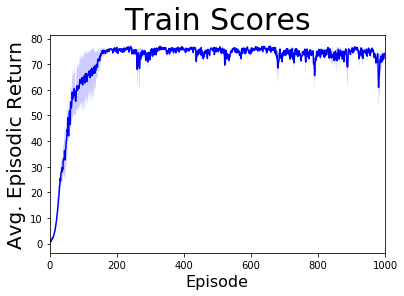

/home/gerti/miniconda3/envs/rl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


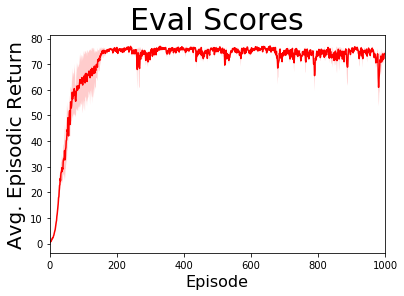

In [13]:
data = None
if os.path.isfile(os.path.join(log_dir, pickl_name)):
    with open(os.path.join(log_dir, pickl_name), mode='rb') as pf:
        data = pickle.load(pf)
        data[seed] = (undisc_G, undisc_eval_G)
    with open(os.path.join(log_dir, pickl_name), mode='wb') as pf:
        pickle.dump(data, pf)
else:
    with open(os.path.join(log_dir, pickl_name), mode='wb') as pf:
        pickle.dump({seed:(undisc_G, undisc_eval_G)}, pf)

if data is not None:
    plot_scores(data)